## Часть 1: Первоначальное обучение модели


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.utils import class_weight
from datetime import datetime

# Настройки
DATA_DIR = "/content/drive/MyDrive/product_images_500"  # Путь к изображениям
IMG_SIZE = (300, 300)  # Увеличили размер для EfficientNetB3
BATCH_SIZE = 32
EPOCHS = 50  # Максимальное количество эпох

# Генерация уникального имени для модели
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = f"best_model_{timestamp}.keras"
MODEL_SAVE_PATH = f"/content/drive/MyDrive/colab_models/{MODEL_NAME}"

# Получаем список всех категорий из папок
CATEGORIES = sorted([d for d in os.listdir(DATA_DIR)
                   if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(CATEGORIES)

print(f"Найдено {NUM_CLASSES} категорий: {CATEGORIES}")

Найдено 28 категорий: ['Автомототехника', 'Автотовары', 'Антиквариат и коллекционирование', 'Аптека', 'Бытовая техника', 'Бытовая химия', 'Галантерея и аксессуары', 'Детские товары', 'Дом и сад', 'Канцелярские товары', 'Кино, музыка, видеоигры, софт', 'Книги', 'Красота и гигиена', 'Мебель', 'Музыкальные инструменты', 'Обувь', 'Одежда', 'Продукты питания', 'Продукты питания Ozon Fresh', 'Спорт и отдых', 'Строительство и ремонт', 'Товары для взрослых', 'Товары для животных', 'Товары для курения и аксессуары', 'Фермерское хозяйство', 'Хобби и творчество', 'Электроника', 'Ювелирные изделия']


In [4]:
# Улучшенный генератор данных с аугментацией
train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Генератор для валидации - без аугментации
val_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# Генераторы данных
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=CATEGORIES,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=CATEGORIES,
    shuffle=False
)

# Проверка распределения классов
print("\nРаспределение по классам:")
class_counts = {}
for cls, idx in train_generator.class_indices.items():
    count = sum(train_generator.classes == idx)
    class_counts[cls] = count
    print(f"{cls}: {count} изображений")

# Рассчитываем веса классов
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 9887 images belonging to 28 classes.
Found 2466 images belonging to 28 classes.

Распределение по классам:
Автомототехника: 76 изображений
Автотовары: 400 изображений
Антиквариат и коллекционирование: 367 изображений
Аптека: 399 изображений
Бытовая техника: 400 изображений
Бытовая химия: 293 изображений
Галантерея и аксессуары: 400 изображений
Детские товары: 400 изображений
Дом и сад: 400 изображений
Канцелярские товары: 400 изображений
Кино, музыка, видеоигры, софт: 400 изображений
Книги: 400 изображений
Красота и гигиена: 400 изображений
Мебель: 400 изображений
Музыкальные инструменты: 287 изображений
Обувь: 400 изображений
Одежда: 400 изображений
Продукты питания: 397 изображений
Продукты питания Ozon Fresh: 191 изображений
Спорт и отдых: 400 изображений
Строительство и ремонт: 400 изображений
Товары для взрослых: 400 изображений
Товары для животных: 400 изображений
Товары для курения и аксессуары: 49 изображений
Фермерское хозяйство: 228 изображений
Хобби и творчество: 400 

In [5]:
# Создаем улучшенную модель
def create_improved_model():
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'
    )

    # Частично размораживаем верхние слои
    base_model.trainable = False

    for layer in base_model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    return model

model = create_improved_model()
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,712,075 (44.68 MB)

 Trainable params: 3,751,804 (14.31 MB)

 Non-trainable params: 7,960,271 (30.37 MB)

In [6]:
# Улучшенные коллбеки с сохранением на Google Drive
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

# Обучение с учетом весов классов
print("\nНачало обучения...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print(f"\nЛучшая модель сохранена на Google Drive: {MODEL_SAVE_PATH}")


Начало обучения...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1060 - loss: 5.0224 - precision: 0.2065 - recall: 0.0336 
Epoch 1: val_accuracy improved from -inf to 0.42863, saving model to /content/drive/MyDrive/colab_models/best_model_20250727_094038.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 4476s 14s/step - accuracy: 0.1062 - loss: 5.0210 - precision: 0.2070 - recall: 0.0337 - val_accuracy: 0.4286 - val_loss: 3.2582 - val_precision: 0.9006 - val_recall: 0.1910 - learning_rate: 1.0000e-04
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3087 - loss: 3.7710 - precision: 0.5753 - recall: 0.1841
Epoch 2: val_accuracy improved from 0.42863 to 0.50852, saving model to /content/drive/MyDrive/colab_models/best_model_20250727_094038.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.3088 - loss: 3.7707 - precision: 0.5754 - recall: 0.1842 - val_accuracy: 0.5085 - val_loss: 2.8822 - val_precision: 0.7970 - val_recall: 0.3471 - learning_rate: 1.0000e-04
Epoch 3/50
309/30

KeyError: 'lr'

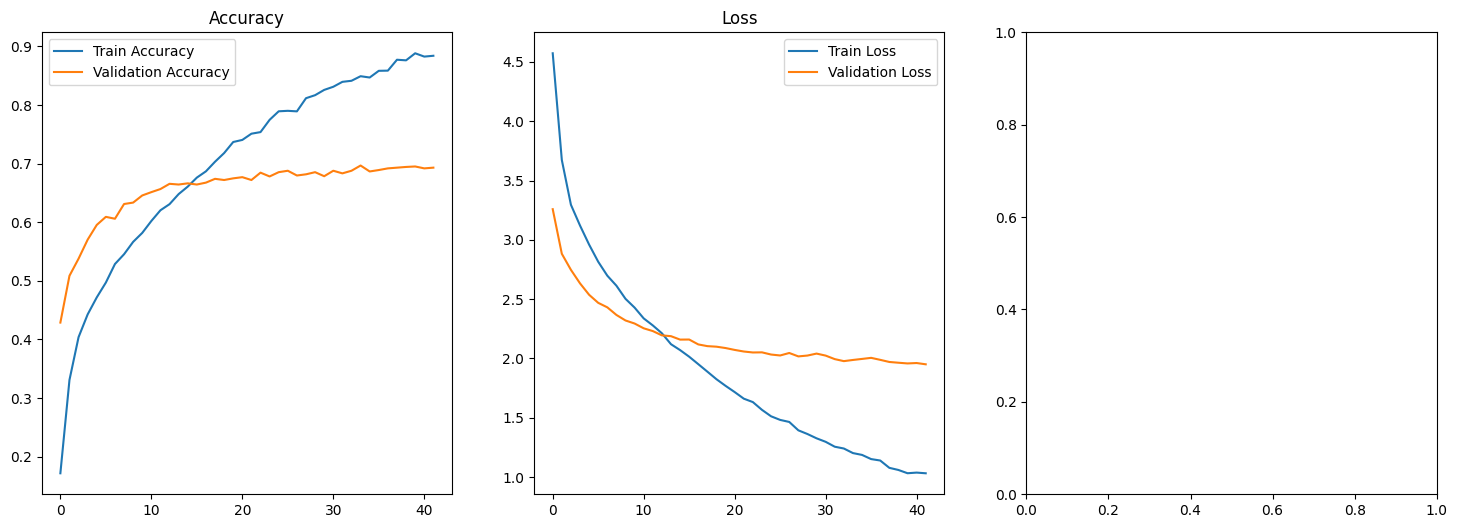

In [7]:
# Визуализация обучения
def plot_history(history):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 787ms/step

Classification Report:
                                  precision    recall  f1-score   support

                 Автомототехника       0.90      0.95      0.92        19
                      Автотовары       0.73      0.74      0.73       100
Антиквариат и коллекционирование       0.71      0.82      0.76        91
                          Аптека       0.57      0.52      0.54        99
                 Бытовая техника       0.58      0.64      0.61       100
                   Бытовая химия       0.88      0.78      0.83        73
         Галантерея и аксессуары       0.69      0.73      0.71        99
                  Детские товары       0.64      0.51      0.57       100
                       Дом и сад       0.76      0.82      0.79       100
             Канцелярские товары       0.38      0.51      0.44       100
   Кино, музыка, видеоигры, софт       0.78      0.59      0.67        99
                           Книги       0.65  

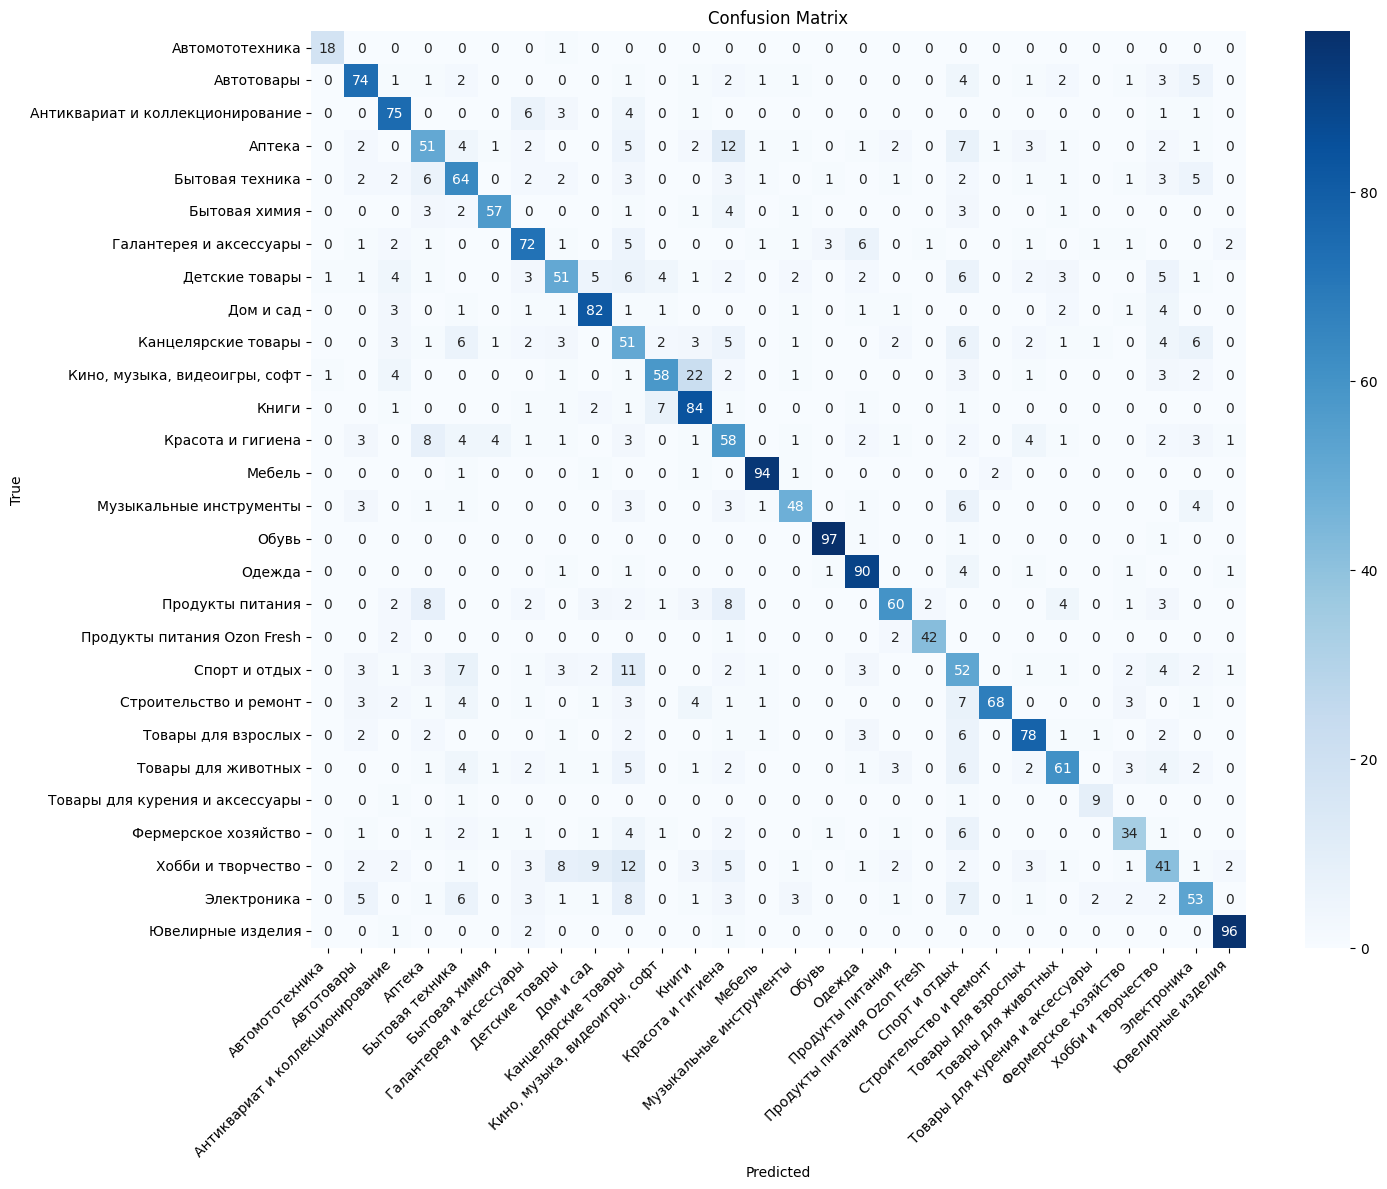

In [8]:
# Оценка модели
val_preds = model.predict(val_generator)
val_pred_classes = np.argmax(val_preds, axis=1)

print("\nClassification Report:")
print(classification_report(
    val_generator.classes,
    val_pred_classes,
    target_names=CATEGORIES
))

# Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES,
            yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Часть 2: Дополнительное обучение с размороженными слоями

In [4]:
# Генерация уникального имени для второй модели
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME_2 = f"best_model_{timestamp}_2.keras"
MODEL_SAVE_PATH_2 = f"/content/drive/MyDrive/colab_models/{MODEL_NAME_2}"

# 1. Загрузка лучшей сохраненной модели
MODEL_SAVE_PATH = '/content/drive/MyDrive/colab_models/best_model_20250727_094038.keras'
best_model = keras.models.load_model(MODEL_SAVE_PATH)
print("✅ Модель успешно загружена!")

# 2. Разморозка последних 50 слоев EfficientNet
base_model = best_model.layers[0]
for layer in base_model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# 3. Добавление новых регуляризационных слоев
x = base_model.output
x = layers.Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

✅ Модель успешно загружена!


In [5]:
# 4. Focal Loss функция
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        ce = keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1 - pt, gamma) * ce
        return tf.reduce_mean(loss)
    return loss

# 5. Настройка оптимизатора Adam с weight decay
class AdamWeightDecay(keras.optimizers.Adam):
    def __init__(self, weight_decay=0.0, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        if self.weight_decay != 0.0:
            grad = grad + self.weight_decay * var
        return super()._resource_apply_dense(grad, var, apply_state=apply_state)

optimizer = AdamWeightDecay(
    learning_rate=0.0005,
    weight_decay=0.0001
)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')]
)

In [7]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import layers
# import tensorflow as tf
# import keras

# # 6. Улучшенный генератор данных с современными параметрами
# def create_augmenter():
#     """Создает последовательность аугментаций с поддержкой контраста и насыщенности"""
#     def augment_fn(image):
#         # Препроцессинг для EfficientNet
#         image = keras.applications.efficientnet.preprocess_input(image)

#         # Применяем аугментации с помощью tf.image
#         image = tf.image.random_brightness(image, max_delta=0.3)  # ~[0.7, 1.3]
#         image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#         image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
#         image = tf.image.random_hue(image, max_delta=0.1)

#         return image

#     return augment_fn

# # Основной генератор для тренировки
# train_datagen = ImageDataGenerator(
#     preprocessing_function=create_augmenter(),
#     rotation_range=30,
#     width_shift_range=0.25,
#     height_shift_range=0.25,
#     shear_range=0.25,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# # Генератор для валидации (без аугментаций)
# val_datagen = ImageDataGenerator(
#     preprocessing_function=keras.applications.efficientnet.preprocess_input,
#     validation_split=0.2
# )

# # Создаем генераторы потоков данных
# train_generator = train_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True,
#     seed=42
# )

# val_generator = val_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False,
#     seed=42
# )

# # Альтернативный современный вариант (если используете Model.fit)
# data_augmentation = Sequential([
#     layers.RandomBrightness(factor=0.3),  # Яркость ±30%
#     layers.RandomContrast(factor=0.2),    # Контраст ±20%
#     layers.RandomFlip(mode="horizontal_and_vertical"),  # Отражение по горизонтали и вертикали
#     layers.RandomRotation(factor=0.1),    # Поворот ±10%
#     layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Зум ±20%
#     layers.RandomTranslation(height_factor=0.25, width_factor=0.25),  # Сдвиг ±25%
#     layers.RandomShear(x_factor=0.25, y_factor=0.25)  # Исправлено: раздельные x/y факторы
# ])

Found 9887 images belonging to 28 classes.
Found 2466 images belonging to 28 classes.


NameError: name 'Sequential' is not defined

In [14]:
from google.colab import drive
import os

# 1. Подключите Google Drive
drive.mount('/content/drive')

# 2. Проверьте правильный путь к данным
DATA_DIR = "/content/drive/MyDrive/colab_models/best_model_20250727_094038.keras"  # Поменяйте на ваш реальный путь

# 3. Проверка существования папки
if not os.path.exists(DATA_DIR):
    print("\n❌ Ошибка: Папка не найдена! Проверьте:")
    print(f"1. Путь: {DATA_DIR}")
    print("2. Структуру вашего Google Drive")
    print("3. Наличие папки 'colab_data/product_categories'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

# # Константы (замените на свои значения)
# DATA_DIR = "/content/drive/MyDrive/colab_models/best_model_20250727_094038.keras"  # Путь к вашим данным
# IMG_SIZE = (224, 224)  # Если исходная модель EfficientNetB0
# BATCH_SIZE = 48  # Оптимально для Colab с GPU T4

# 1. Создание функции аугментации
def create_augmenter():
    """Функция для аугментации изображений с сохранением препроцессинга EfficientNet"""
    def augment_fn(image):
        # Препроцессинг для EfficientNet
        image = keras.applications.efficientnet.preprocess_input(image)

        # Аугментации цвета
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.1)

        return image

    return augment_fn

# 2. Создание генератора для тренировки
train_datagen = ImageDataGenerator(
    preprocessing_function=create_augmenter(),
    rotation_range=30,            # Поворот на ±30 градусов
    width_shift_range=0.25,      # Горизонтальный сдвиг ±25%
    height_shift_range=0.25,     # Вертикальный сдвиг ±25%
    shear_range=0.25,            # Сдвиг ±25%
    zoom_range=0.25,             # Зум ±25%
    horizontal_flip=True,        # Горизонтальное отражение
    vertical_flip=True,          # Вертикальное отражение
    fill_mode='nearest',         # Способ заполнения пустот
    validation_split=0.2         # Разделение на train/val
)

# 3. Создание генератора для валидации (без аугментаций)
val_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# 4. Создание потоков данных
try:
    train_generator = train_datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_generator = val_datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=42
    )

    print("✅ Генераторы успешно созданы!")
    print(f"Тренировочные данные: {train_generator.samples} изображений")
    print(f"Валидационные данные: {val_generator.samples} изображений")

except Exception as e:
    print(f"❌ Ошибка при создании генераторов: {e}")
    print("Проверьте:")
    print(f"1. Путь к данным: {DATA_DIR}")
    print("2. Структуру папок (должна быть class/subfolder/)")
    print("3. Версии библиотек (TensorFlow 2.6+)")

# 5. Альтернативный вариант аугментации (для Model.fit)
data_augmentation = Sequential([
    layers.RandomBrightness(factor=0.3),
    layers.RandomContrast(factor=0.2),
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomTranslation(height_factor=0.25, width_factor=0.25),
    layers.RandomShear(x_factor=0.25, y_factor=0.25)
], name="data_augmentation")

print("\nАльтернативный аугментатор создан:", data_augmentation.name)

Found 9887 images belonging to 28 classes.
Found 2466 images belonging to 28 classes.
✅ Генераторы успешно созданы!
Тренировочные данные: 9887 изображений
Валидационные данные: 2466 изображений

Альтернативный аугментатор создан: data_augmentation


In [17]:
# # 7. Создание генераторов с улучшенными параметрами аугментации
# train_datagen = ImageDataGenerator(
#     preprocessing_function=keras.applications.efficientnet.preprocess_input,
#     brightness_range=[0.7, 1.3],
#     contrast_range=[0.8, 1.2],
#     saturation_range=[0.8, 1.2],
#     hue_range=0.1,
#     rotation_range=30,
#     width_shift_range=0.25,
#     height_shift_range=0.25,
#     shear_range=0.25,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# val_datagen = ImageDataGenerator(
#     preprocessing_function=keras.applications.efficientnet.preprocess_input,
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True,
#     classes=CATEGORIES
# )

# val_generator = val_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False,
#     classes=CATEGORIES
# )

# # Проверка что генераторы работают
# print("\nКлассы в train_generator:", train_generator.class_indices)
# print("Классы в val_generator:", val_generator.class_indices)

TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'contrast_range'

In [18]:
# # 8. Новые коллбеки с сохранением на Google Drive
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=5,
#         min_delta=0.001,
#         restore_best_weights=True
#     ),
#     keras.callbacks.ModelCheckpoint(
#         MODEL_SAVE_PATH_2,
#         monitor='val_accuracy',
#         save_best_only=True
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=3,
#         min_lr=1e-6,
#         verbose=1
#     )
# ]

# # 9. Продолжение обучения
# print("\nПродолжение обучения улучшенной модели...")
# history = model.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     callbacks=callbacks,
#     class_weight=class_weights
# )

# print(f"\nЛучшая модель второй части сохранена на Google Drive: {MODEL_SAVE_PATH_2}")


Продолжение обучения улучшенной модели...


NameError: name 'class_weights' is not defined

In [19]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow import keras

# 8. Новые коллбеки с сохранением на Google Drive
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH_2,
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 8.1. Расчет весов классов для несбалансированных данных
print("\nРасчет весов классов...")
train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Веса классов:", class_weights)

# 9. Продолжение обучения с учетом весов классов
print("\nПродолжение обучения улучшенной модели...")
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights  # Используем рассчитанные веса
)

print(f"\n✅ Лучшая модель второй части сохранена на Google Drive: {MODEL_SAVE_PATH_2}")


Расчет весов классов...
Веса классов: {0: np.float64(4.646146616541353), 1: np.float64(0.8827678571428571), 2: np.float64(0.9621448034254574), 3: np.float64(0.8849803079126387), 4: np.float64(0.8827678571428571), 5: np.float64(1.205143832276938), 6: np.float64(0.8827678571428571), 7: np.float64(0.8827678571428571), 8: np.float64(0.8827678571428571), 9: np.float64(0.8827678571428571), 10: np.float64(0.8827678571428571), 11: np.float64(0.8827678571428571), 12: np.float64(0.8827678571428571), 13: np.float64(0.8827678571428571), 14: np.float64(1.2303384768541563), 15: np.float64(0.8827678571428571), 16: np.float64(0.8827678571428571), 17: np.float64(0.889438646995322), 18: np.float64(1.8487284966342559), 19: np.float64(0.8827678571428571), 20: np.float64(0.8827678571428571), 21: np.float64(0.8827678571428571), 22: np.float64(0.8827678571428571), 23: np.float64(7.206268221574344), 24: np.float64(1.5487155388471179), 25: np.float64(0.8827678571428571), 26: np.float64(0.8827678571428571), 27

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 4460s 14s/step - accuracy: 0.3875 - loss: 6.0835 - precision: 0.5631 - recall: 0.2986 - val_accuracy: 0.6030 - val_loss: 1.7670 - val_precision: 0.8613 - val_recall: 0.4282 - learning_rate: 5.0000e-04
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.5918 - loss: 1.3783 - precision: 0.7734 - recall: 0.4632 - val_accuracy: 0.6217 - val_loss: 0.7254 - val_precision: 0.8303 - val_recall: 0.4740 - learning_rate: 5.0000e-04
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.6391 - loss: 0.6417 - precision: 0.8114 - recall: 0.5152 - val_accuracy: 0.5985 - val_loss: 0.5672 - val_precision: 0.8369 - val_recall: 0.4599 - learning_rate: 5.0000e-04
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.6726 - loss: 0.4831 - precision: 0.8362 - recall: 0.5506 - val_accuracy: 0.6285 - val_loss: 0.5163 - val_precision: 0.7979 - val_recall: 0.5219 - learning_rate: 5.0000e-04
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 50

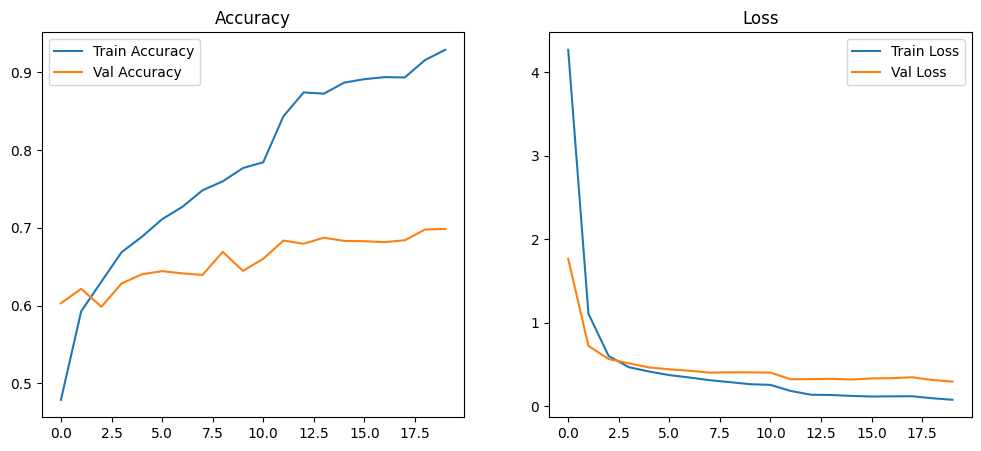

78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 768ms/step

Classification Report:
                                  precision    recall  f1-score   support

                 Автомототехника       0.94      0.89      0.92        19
                      Автотовары       0.80      0.77      0.79       100
Антиквариат и коллекционирование       0.71      0.78      0.74        91
                          Аптека       0.66      0.45      0.54        99
                 Бытовая техника       0.49      0.66      0.56       100
                   Бытовая химия       0.77      0.73      0.75        73
         Галантерея и аксессуары       0.74      0.70      0.72        99
                  Детские товары       0.54      0.60      0.57       100
                       Дом и сад       0.72      0.84      0.78       100
             Канцелярские товары       0.39      0.46      0.42       100
   Кино, музыка, видеоигры, софт       0.83      0.75      0.79        99
                           Книги       0.73  

In [20]:
# Визуализация и оценка
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

val_preds = model.predict(val_generator)
val_pred_classes = np.argmax(val_preds, axis=1)

print("\nClassification Report:")
print(classification_report(
    val_generator.classes,
    val_pred_classes,
    target_names=CATEGORIES
))

## часть 3

In [7]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, regularizers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# from sklearn.utils import class_weight

# # 1. Настройки
# DATA_DIR = "/content/drive/MyDrive/product_images_500"
# WEAK_CLASSES = ["Электроника", "Фермерское хозяйство", "Канцелярские товары"]  # Категории с ΔF1 < -0.05
# IMG_SIZE = (300, 300)
# BATCH_SIZE = 32
# EPOCHS = 10

# # 2. Загрузка модели

# import tensorflow as tf
# from tensorflow.keras import optimizers

# # 1. Определяем кастомный оптимизатор (если нужно)
# class AdamWeightDecay(optimizers.Adam):
#     def __init__(self, weight_decay=0.01, **kwargs):
#         super().__init__(**kwargs)
#         self.weight_decay = weight_decay

# # 2. Загружаем модель с заменой оптимизатора
# try:
#     model = tf.keras.models.load_model(
#         '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras',
#         custom_objects={'AdamWeightDecay': AdamWeightDecay}
#     )
# except Exception as e:
#     print(f"Ошибка загрузки: {e}")
#     # Альтернативный способ
#     model = tf.keras.models.load_model(
#         '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras',
#         compile=False
#     )
#     model.compile(
#         optimizer=optimizers.Adam(learning_rate=0.0001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

# # 3. Проверка модели
# print("Архитектура модели:")
# model.summary()

# print("\nПроверка работоспособности:")
# import numpy as np
# dummy_input = np.random.rand(1, *model.input_shape[1:])
# print(model.predict(dummy_input))

# # 3. Проверка модели
# print("Архитектура модели:")
# model.summary()

# print("\nПроверка работоспособности:")
# import numpy as np
# dummy_input = np.random.rand(1, *model.input_shape[1:])
# print(model.predict(dummy_input))

# # model_path = '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras'
# # model = keras.models.load_model(model_path)

# # 3. Подготовка данных для проблемных классов
# def get_class_specific_augmentation(class_name):
#     if class_name == "Электроника":
#         return {
#             'rotation_range': 45,
#             'width_shift_range': 0.3,
#             'brightness_range': [0.7, 1.3]
#         }
#     elif class_name == "Фермерское хозяйство":
#         return {
#             'zoom_range': 0.4,
#             'height_shift_range': 0.3,
#             'horizontal_flip': True
#         }
#     else:  # Для остальных слабых классов
#         return {
#             'rotation_range': 30,
#             'width_shift_range': 0.2
#         }

# # 4. Генераторы данных с усиленной аугментацией для слабых классов
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     **get_class_specific_augmentation('combined'),
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# # 5. Расчет весов классов
# class_indices = train_generator.class_indices
# reverse_class_indices = {v: k for k, v in class_indices.items()}

# # Усиление весов для проблемных классов
# class_weights = class_weight.compute_class_weight(
#     'balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))

# for cls_name in WEAK_CLASSES:
#     if cls_name in class_indices:
#         class_weights[class_indices[cls_name]] *= 2.0  # Удваиваем вес

# # 6. Адаптивный Focal Loss
# def adaptive_focal_loss(gamma=2.0, alpha=0.25):
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         ce = keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
#         pt = tf.exp(-ce)
#         loss = alpha * tf.pow(1 - pt, gamma) * ce

#         # Усиление потерь для слабых классов
#         class_mask = tf.reduce_max(y_true * [1.0 if reverse_class_indices[i] in WEAK_CLASSES else 0.5
#                                            for i in range(len(class_indices))], axis=-1)
#         return tf.reduce_mean(loss * (1.0 + class_mask))
#     return loss

# # 7. Разморозка верхних слоев
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # 8. Компиляция с новыми параметрами
# model.compile(
#     optimizer=Adam(learning_rate=0.0001, weight_decay=0.0001),
#     loss=adaptive_focal_loss(),
#     metrics=['accuracy',
#             keras.metrics.Precision(name='precision'),
#             keras.metrics.Recall(name='recall')]
# )

# # 9. Коллбеки
# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/colab_models/stage3_best_model.keras',
#         monitor='val_recall',  # Фокусируемся на recall для слабых классов
#         save_best_only=True,
#         mode='max'
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=3,
#         min_lr=1e-6
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor='val_f1_score',  # Нужна кастомная метрика
#         patience=5,
#         restore_best_weights=True
#     )
# ]

# # 10. Кастомная метрика F1
# class F1Score(keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super().__init__(name=name, **kwargs)
#         self.precision = keras.metrics.Precision()
#         self.recall = keras.metrics.Recall()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         self.precision.update_state(y_true, y_pred, sample_weight)
#         self.recall.update_state(y_true, y_pred, sample_weight)

#     def result(self):
#         p = self.precision.result()
#         r = self.recall.result()
#         return 2 * ((p * r) / (p + r + 1e-6))

#     def reset_state(self):
#         self.precision.reset_state()
#         self.recall.reset_state()

# model.compile(
#     optimizer=model.optimizer,
#     loss=model.loss,
#     metrics=[*model.metrics, F1Score()]
# )

# # 11. Дообучение
# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     class_weight=class_weights,
#     callbacks=callbacks,
#     validation_data=val_generator
# )

# # 12. Сохранение финальной версии
# model.save('/content/drive/MyDrive/colab_models/final_model_stage3.keras')

# # 13. Визуализация результатов
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['f1_score'], label='Train F1')
# plt.plot(history.history['val_f1_score'], label='Val F1')
# plt.title('F1 Score')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Loss')
# plt.legend()
# plt.show()

Ошибка загрузки: Could not locate function 'loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'loss', 'registered_name': 'function'}
Архитектура модели:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,586,891 (44.20 MB)

 Trainable params: 5,503,664 (20.99 MB)

 Non-trainable params: 6,083,227 (23.21 MB)


Проверка работоспособности:
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[[3.5382043e-05 1.1961187e-05 1.7076711e-05 8.0454117e-07 5.4905828e-05
  4.7380759e-06 9.6084204e-07 2.9641909e-05 8.6894761e-06 1.3174885e-05
  9.9577904e-01 3.1806240e-03 3.3648269e-06 8.6758801e-06 2.3877085e-04
  1.7279117e-04 1.2270509e-05 4.6608661e-06 1.6219285e-05 1.0037205e-05
  5.4653215e-06 2.5038116e-05 1.4026638e-05 4.3490909e-05 2.0470801e-05
  1.1318275e-05 2.6648625e-04 1.0073606e-05]]
Архитектура модели:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,586,891 (44.20 MB)

 Trainable params: 5,503,664 (20.99 MB)

 Non-trainable params: 6,083,227 (23.21 MB)


Проверка работоспособности:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[3.49707771e-05 1.17070294e-05 1.67826329e-05 7.83552821e-07
  5.37306551e-05 4.67315976e-06 9.37255322e-07 2.90786538e-05
  8.50542165e-06 1.28364491e-05 9.95840073e-01 3.14174988e-03
  3.28513579e-06 8.49654407e-06 2.32929480e-04 1.69693143e-04
  1.19823344e-05 4.58925024e-06 1.59288647e-05 9.81224457e-06
  5.34023548e-06 2.45785122e-05 1.37375118e-05 4.26825281e-05
  1.99731367e-05 1.11515965e-05 2.59955938e-04 9.86692339e-06]]
Found 9887 images belonging to 28 classes.


NameError: name 'val_generator' is not defined

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, regularizers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# from sklearn.utils import class_weight

# # 1. Настройки
# DATA_DIR = "/content/drive/MyDrive/product_images_500"
# WEAK_CLASSES = ["Электроника", "Фермерское хозяйство", "Канцелярские товары"]
# IMG_SIZE = (300, 300)
# BATCH_SIZE = 32
# EPOCHS = 10

# # 2. Загрузка модели с обработкой ошибки оптимизатора
# try:
#     model = keras.models.load_model(
#         '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras',
#         compile=False
#     )
# except TypeError:
#     # Если возникает ошибка AdamWeightDecay
#     model = keras.models.load_model(
#         '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras',
#         custom_objects={'AdamWeightDecay': Adam},
#         compile=False
#     )

# # 3. Создание генераторов данных
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2
# )

# val_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# # Добавляем val_generator который был отсутствовал
# val_generator = val_datagen.flow_from_directory(
#     DATA_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

# # 4. Расчет весов классов
# class_indices = train_generator.class_indices
# class_weights = class_weight.compute_class_weight(
#     'balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))

# # 5. Компиляция модели
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # 6. Обучение
# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,  # Теперь val_generator определен
#     class_weight=class_weights,
#     callbacks=[
#         keras.callbacks.ModelCheckpoint(
#             '/content/drive/MyDrive/colab_models/stage3_best_model.keras',
#             monitor='val_accuracy',
#             save_best_only=True
#         ),
#         keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         )
#     ]
# )

# # 7. Сохранение результатов
# model.save('/content/drive/MyDrive/colab_models/final_model_stage3.keras')

# # 8. Визуализация
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.title('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Loss')
# plt.legend()
# plt.show()

Mounted at /content/drive
Found 9887 images belonging to 28 classes.
Found 2466 images belonging to 28 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 3005s 10s/step - accuracy: 0.9548 - loss: 0.1970 - val_accuracy: 0.7028 - val_loss: 1.3879
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 866s 3s/step - accuracy: 0.9635 - loss: 0.1703 - val_accuracy: 0.6971 - val_loss: 1.4214
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 886s 3s/step - accuracy: 0.9698 - loss: 0.1614 - val_accuracy: 0.6983 - val_loss: 1.4401
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.9684 - loss: 0.1585 - val_accuracy: 0.6951 - val_loss: 1.4770
Epoch 5/10
160/309 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.9702 - loss: 0.1544

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils import class_weight

# 1. Настройки
DATA_DIR = "/content/drive/MyDrive/product_images_500"
WEAK_CLASSES = ["Электроника", "Фермерское хозяйство", "Канцелярские товары"]
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 20  # Увеличили количество эпох

# 2. Создание генераторов данных с улучшенной аугментацией
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,  # Увеличили аугментацию
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],  # Сильнее меняем яркость
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 3. Загрузка модели с обработкой оптимизатора
try:
    model = keras.models.load_model(
        '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras',
        compile=False
    )
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    # Создаем новую модель, если не удалось загрузить
    base_model = keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)  # Увеличили dropout
    x = layers.BatchNormalization()(x)
    predictions = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=predictions)

# 4. Разморозка только верхних слоев
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# 5. Усиленные веса для слабых классов
class_indices = train_generator.class_indices
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

for cls in WEAK_CLASSES:
    if cls in class_indices:
        class_weights[class_indices[cls]] *= 3.0  # Сильнее усиливаем слабые классы

# 6. Компиляция с маленьким learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Уменьшили LR
    loss='categorical_crossentropy',
    metrics=['accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')]
)

# 7. Коллбеки для контроля
# Улучшенные callback'и
callbacks = [
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/colab_models/stage3_best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.001,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Загрузите последние веса (если прерывали)
try:
    model.load_weights('/content/drive/MyDrive/colab_models/stage3_best_model.keras')
except:
    print("Используем текущие веса модели")

# 8 Продолжение обучения
history = model.fit(
    train_generator,
    epochs=20,
    initial_epoch=2,  # Укажите номер последней завершенной эпохи
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# # 8. Обучение
# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     class_weight=class_weights,
#     callbacks=callbacks
# )

# 9. Сохранение и визуализация
model.save('/content/drive/MyDrive/colab_models/final_model_stage3.keras')

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# 10. Отчет по классам
from sklearn.metrics import classification_report
val_pred = model.predict(val_generator)
print(classification_report(
    val_generator.classes,
    np.argmax(val_pred, axis=1),
    target_names=list(class_indices.keys())
))

Found 9887 images belonging to 28 classes.
Found 2466 images belonging to 28 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 3/20
181/309 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.9066 - loss: 0.4032 - precision: 0.9498 - recall: 0.8748